# Using libRadtran in Parallel on a Cluster

This notebook shows how to run a batch of [`libRadtran/uvspec`](http://www.libradtran.org) cases in parallel on a cluster computer using [`ipyparallel`](https://ipyparallel.readthedocs.org/en/latest/). 
The `pyparallel` package provides a flexible, yet reasonably simple way of harnessing mutiple compute cores from the `IPython/Jupyter` notebook environment or in other Python launch modes.

The general `ipyparallel` compute model is that a Hub Controller process is started on a machine that has (preferably secure) network access to both the compute nodes and the user client node. Mutiple worker processes referred to as Engines are then started (on one or more machines) that register with the Hub Controller. The user client process then also contacts the Hub Controller in order to distribute work to the engines.

The main setup required is that of pointing both the client process and the engine processes to the hub controller as well as dealing with any security issues with network access between the machines on which the processes are running. The most simple situation that requires almost no setup is that of running all (hub/controller, client and all worker engines) processes on the same machine. Otherwise it will be necessary to copy JSON configuration files created by the hub/controller to the machines hosting the clients and engines. Detailed information is provided in the [`ipyparallel`](https://ipyparallel.readthedocs.org/en/latest/) documentation.

Note that whenever the hub/controller is started (using the `ipcontroller` or `ipcluster` command) it generates *new* JSON configuration files that must be made available to the clients and engines.

The setup that follows shows a situation involving two machines, a Windows machine that runs the client IPython/Jupyter user interface and a networked Linux host with mutiple compute cores running a single hub controller process and multiple engines up to the number of compute cores available (64 in this case).

Secure sockets (SSH) access from the Windows environment to the host cluster is provided by the [`paramiko`](https://github.com/paramiko/paramiko) Python package. Be warned that installation of `paramiko` on Windows can present some challenges.

In [1]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller
# use latex for font rendering
mpl.rcParams['text.usetex'] = True  # Use TeX to format labels (takes a bit longer)
%matplotlib inline

In [2]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCase=librad.Case(filename='./examples/UVSPEC_AEROSOL.INP')

In [3]:
libRadCase.readout()

In [3]:

# Create 10 copies of the case
import copy
libRadBatch = [copy.deepcopy(libRadCase) for icopy in range(10)]
# Rename each element in the batch, just by appending a digit
# This is to prevent the engines from fighting over input and output files
# Also change the solar zenith angle on each run, so that they are different
solar_zenith_angle = np.linspace(0.0, 80.0, 10)
for icase, libRadCase in enumerate(libRadBatch):
    libRadCase.name = libRadCase.name + '_' + str(icase)
    libRadCase.alter_option(['sza', str(solar_zenith_angle[icase])])
    

In [4]:
# Create the ipyparallel client and contact the hub/controller using the profile called icebow and SSH
# to the machine at the IP address 146.64.246.95
# This will cause ipyparall to look in ~/.ipython/profile_icebow/security for a file named ipcontroller_client.json.
# This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
# it may need to be copied from the host running the hub/controller to the machine running the client.
#
#paraclient = Client(profile='icebow', sshserver='dgriffith@146.64.246.95', password='dgIceBow')
#paraclient = Client(profile='nimbus', sshserver='dgriffith@146.64.246.94', password='dgNimbus')
paraclient = Client(profile='Acer-5730', sshserver='dgriffith@10.0.0.21', password='mandamoggie')

In [6]:
# We will use dill instead of the standard pickle so that we can send instance methods to engines
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [5]:
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True
# We will use dill instead of the standard pickle so that we can send instance methods to engines
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [6]:
# Can attampt to run the case on the local machine, but libRadtran may not be installed, in which case a warning
# is issued and the case does not run
libRadCase.run()

D:\Projects\GitHub\MORTICIA\morticia\rad\librad.py:1307: UserWarning: Unable to spawn uvspec process. Probably not installed system-wide on platform.
  warnings.warn('Unable to spawn uvspec process. Probably not installed system-wide on platform.')


atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/atlas_plus_modtran
mol_modify O3 300. DU
day_of_year 170
albedo 0.2
sza 80.0
rte_solver disort
number_of_streams 6
wavelength 299.0 341.0
slit_function_file ../examples/TRI_SLIT.DAT
spline 300 340 1
quiet 
aerosol_vulcan 1
aerosol_haze 6
aerosol_season 1
aerosol_visibility 20.0
aerosol_angstrom 1.1 0.2
aerosol_modify ssa scale 0.85
aerosol_modify gg set 0.70
aerosol_file tau ../examples/AERO_TAU.DAT

In [7]:
# Now try to run the batch on the cluster
libRadBatch = paraview.map(librad.Case.run, libRadBatch)

In [8]:
libRadBatch[1].run_return_code

0

In [9]:
edir = np.hstack([libRadBatch[i].edir for i in range(len(libRadBatch))]) 

edir.shape

(41L, 10L)

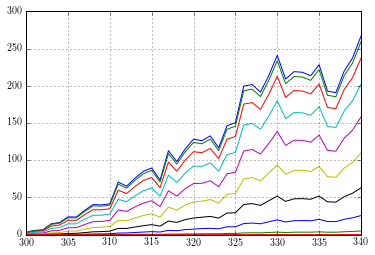

In [10]:
# Plot direct irradiance for all 10 cases
plt.plot(libRadBatch[0].wvl, edir)
plt.grid()


In [ ]:
print edir[:,2]

In [ ]:
a

In [ ]:
flattened  = [val for sublist in a for val in sublist]

In [ ]:
 = map(lambda x:x**2, flattened)

In [ ]:
class tit:
    def __init__(self, val):
        self.a = val
        
    def sqr(self):
        self.a *= self.a
        return self

In [ ]:
x = tit(10)


In [ ]:
x.a

In [ ]:
import copy
myl = [[copy.deepcopy(x) for i in range(8)] for j in range(10)]

In [ ]:
myl[0][0].a = 4
myl[0][1].a = 9

In [ ]:
myl[1][1].a

In [ ]:
from itertools import chain
mylf = list(chain(*myl))

In [ ]:
mylf[0].a

In [ ]:
mylf = map(tit.sqr, mylf)

In [ ]:
len(mylf)

In [ ]:
49**2

In [ ]:
a = tit(3.141)

In [ ]:
l = [a, a, 3, 4]

In [ ]:
b = l[0]

In [ ]:
b

In [ ]:
b.a = 10

In [ ]:
a.a

In [ ]:
mylback = [[mylf[j*8 + i] for i in range(8)] for j in range(10)]

In [ ]:
len(mylback)

In [ ]:
myl[4][5].a

In [ ]:
mylback[4][5].a = 45.5555

In [ ]:
import numpy as np
a = np.array([])

In [ ]:
a

In [ ]:
mc = librad.Case(filename='./examples/UVSPEC_MC_BPDF.INP')

In [ ]:
mc.alter_option(['mc_photons', '1000'])
mc

In [ ]:
mc.readout()

In [ ]:
mc.n_wvl

In [ ]:
# Now try to run the case on the cluster
mcout = paraview.apply_sync(librad.Case.run, mc)

In [ ]:
mcout.n_wvl

In [ ]:
libRadCase.fluxline

In [ ]:
libRadCase.n_levels_out

In [ ]:
libRadCase.n_wvl

In [ ]:
libRadCase.edir.shape

In [ ]:
libRadCase.fluxdata.shape

In [ ]:
libRadCase.fluxdata

In [ ]:
libRadCase.fluxline

In [ ]:
'wvl' in libRadCase.fluxline

In [ ]:
import numpy as np

In [ ]:
np.array([]).size

In [ ]:
mc.xd_uavgdir

In [12]:
100*24

2400